In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import pickle as pkl

%run ../../scripts/mfss_model_train.py
%run ../../scripts/coherence_analysis_and_transform.py
%run ../../scripts/utils/data_processing.py
%run ../../scripts/figure_plots.py
%matplotlib inline

# Load in training and test data

In [2]:
data_path = '../../data/processed/'

In [3]:
# Read in the Hannum dataset for training
hannum = pd.read_pickle(data_path + 'GSE40279_hannum/hannum32.pkl')
hannum_meta = pd.read_excel(data_path + 'GSE40279_hannum/hannum_pmeta.xlsx')

In [4]:
# Read in the Lehne datasat for testing
lehne = np.load(data_path + 'GSE55763_lehne/lehne32_reduced.npy')
lehne_meta = pd.read_excel(data_path + 'GSE55763_lehne/lehne_pmeta.xlsx')
lehne_cgs = list_reader(data_path + 'GSE55763_lehne/cgs')
lehne = pd.DataFrame(lehne, columns=lehne_cgs)

In [4]:
art = np.load(data_path + 'GSE42861_arthritis/arthritis32_full.npy', allow_pickle=True)
art_meta = pd.read_excel(data_path + 'GSE42861_arthritis/arthritis_pmeta.xlsx')
cgs=list_reader(data_path + 'GSE42861_arthritis/cgs_full.txt')
art = pd.DataFrame(art, columns=cgs)

### Read in the filtered (less SNPs and CpGs missing from GSE55763) age correlations 'filtered_age_corrs.xlsx' stored in 'cpg_sets' directory

In [16]:
age_corrs=pd.read_excel(data_path + 'cpg_sets/filtered_age_corrs.xlsx')

In [384]:
#Identify arthritis-shifted CpGs
up_shift, down_shift = get_shifts(art, art_meta, age_corrs.CpG[:10000], 'Control')

#Combine
d_shift = pd.concat([up_shift,down_shift])
d_shift.reset_index(inplace=True, drop=True)
d_shift.sort_values(by='Order', ignore_index=True, inplace=True,ascending=True)

### Note: 'Correlation' in d_shift refers to the age correlation of the CpG within the dataset passed into get_shifts (e.g. arthritis), while 'Order' refers to the rank of the CpG within the CpG list passed into get_shifts (e.g. 'filtered_age_corrs', which is ranked by age correlation in the GSE40279 dataset)

# Generate Supplementary Table 3

In [385]:
#Get correlation magnitudes, sort correlation magnitude (descending)
d_shift['Abs. correlation'] = abs(d_shift.Correlation)
d_shift['Abs. d'] = abs(d_shift['Cohens d'])
d_shift

,CpG,Shift,Correlation,Cohens d,Sign,Order,Abs. correlation,Abs. d
0,cg16867657,-0.009140,0.847155,0.663105,-1,0,0.847155,0.663105
1,cg06639320,-0.007488,0.720896,0.569131,-1,1,0.720896,0.569131
2,cg24724428,-0.014181,0.658811,0.895964,-1,2,0.658811,0.895964
3,cg22454769,0.009697,0.730099,-0.629524,1,3,0.730099,0.629524
4,cg24079702,0.006215,0.605845,-0.412700,1,4,0.605845,0.412700
...,...,...,...,...,...,...,...,...
9995,cg03085932,0.001308,-0.022486,-0.088130,1,9995,0.022486,0.088130
9996,cg20786246,-0.004547,0.091143,0.452967,-1,9996,0.091143,0.452967
9997,cg21463605,-0.013455,-0.059341,0.724346,-1,9997,0.059341,0.724346
9998,cg14180030,-0.018956,-0.097448,1.669450,-1,9998,0.097448,1.669450


In [324]:
# Reduce the datasets to only the top 10,000 age correlated CpGs
hannum=hannum[d_shift.CpG]
lehne=lehne[d_shift.CpG]
art=art[d_shift.CpG]

### Get the transformed data for the training (Hannum), validation (Lehne), and test (arthritis) sets

In [293]:
hannum_transform = coherence_transform(hannum, d_shift)
print('Done')
lehne_transform = coherence_transform(lehne, d_shift)
print('Done')
art_transform = coherence_transform(art, d_shift)

Done
Done


### Train an mFSS OLS model on RA-rectified features, with features added in based on their age correlation in the training set (GSE40279)

In [386]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(d_shift.CpG.tolist(), hannum_transform, 
                                                                          hannum_meta,lehne_transform, lehne_meta,
                                                                          patience=800,rand_state=42,
                                                                          pos_weights=True)

# Generate Supplementary Figure 4a (top)

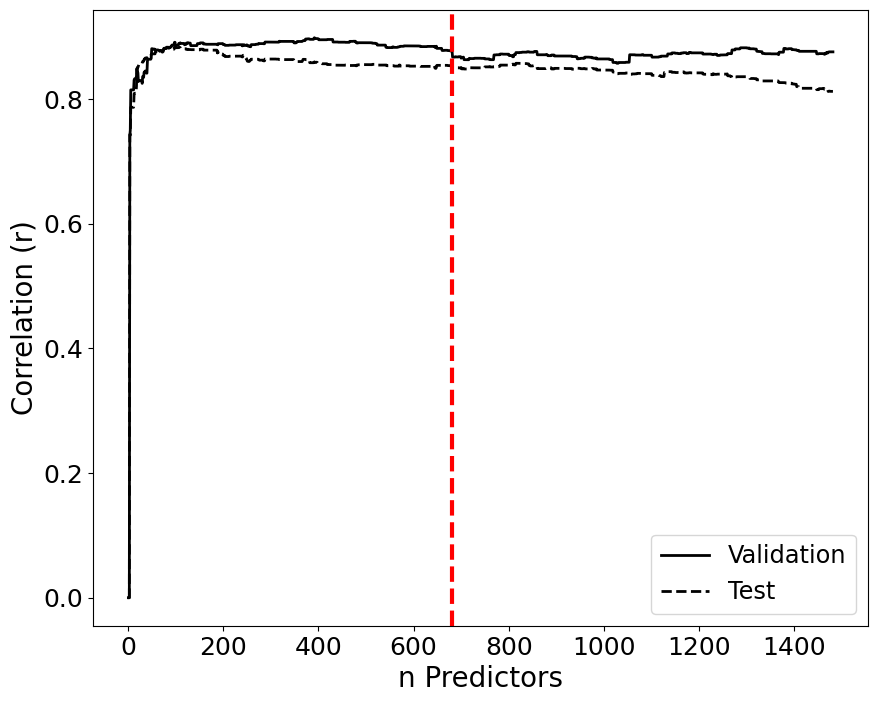

In [387]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20)
plt.ylabel('Correlation (r)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize='xx-large')

# Generate Supplementary Figure 4a (bottom)

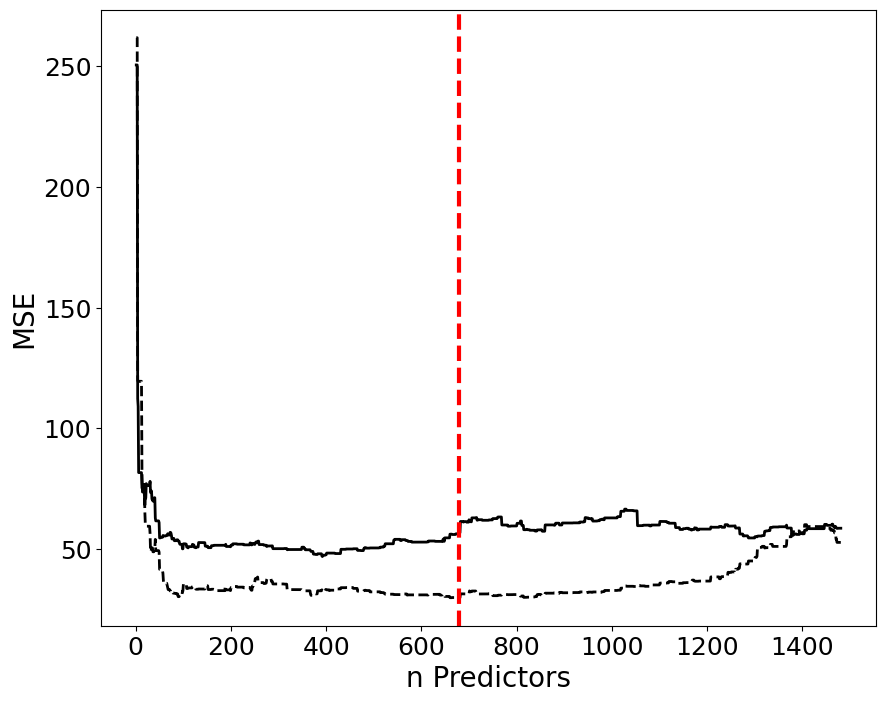

In [388]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20);
plt.ylabel('MSE',fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

In [389]:
best_iter

680

### Train the optimized model

In [390]:
art_corr_mfss_selection = age_corrs.CpG[:best_iter]
art_corr_mfss_model = LinearRegression(positive=True).fit(hannum_transform[art_corr_mfss_selection], hannum_meta.age)

# Generate Supplementary Table 4

In [393]:
model_df = pd.DataFrame({'Feature': art_corr_mfss_model.feature_names_in_, 'Weight': art_corr_mfss_model.coef_})
new_row = {'Feature': 'Intercept', 'Weight': art_corr_mfss_model.intercept_, 'Signal shift': 'NA', 'Reflect': 'NA'}
model_df = model_df[model_df.Weight!=0].reset_index(drop=True)
# sort the rows by CpG
model_df.sort_values('Feature', inplace=True, ignore_index=True)

# Create a filter for the rows in d_shift where CpG values are in model_df.Feature
filtered_d_shift = d_shift[d_shift.CpG.isin(model_df.Feature)].copy()
# sort the rows by CpG to match the row order of model_df
filtered_d_shift.sort_values('CpG', inplace=True, ignore_index=True)

model_df['Signal shift'] = filtered_d_shift.Shift.tolist()
model_df['Reflect'] = filtered_d_shift.Sign.tolist()
# Replace 1 with 'False' and -1 with 'True' indicating if the feature was reflected
model_df['Reflect'] = model_df['Reflect'].replace({1: False, -1: True})
# Add the new row
model_df.loc[len(model_df)] = new_row
model_df

,Feature,Weight,Signal shift,Reflect
0,cg00103778,16.455812,0.001677,False
1,cg00210249,11.286157,0.00727,False
2,cg00308841,4.345771,0.001553,False
3,cg00327072,7.449950,0.000133,False
4,cg00387658,11.168719,0.005229,False
...,...,...,...,...
120,cg26210267,10.808466,-0.00311,True
121,cg26424147,12.467615,0.004448,False
122,cg27068143,3.556774,0.000446,False
123,cg27346545,1.126347,-0.012131,True


### Load in GSE72774 (Parkinson's disease) dataset

In [320]:
park = pd.read_pickle(data_path + 'GSE72774_parkinsons/parkinsons32.pkl')
park_meta = pd.read_excel(data_path + 'GSE72774_parkinsons/parkinsons_pmeta.xlsx')
park=park.reset_index(drop=True)
from sklearn.impute import KNNImputer
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=2)
# Fit and transform the DataFrame with the imputer
imputed = imputer.fit_transform(park)
park = pd.DataFrame(imputed, columns=park.columns)

# Generate Supplementary Figure 4b

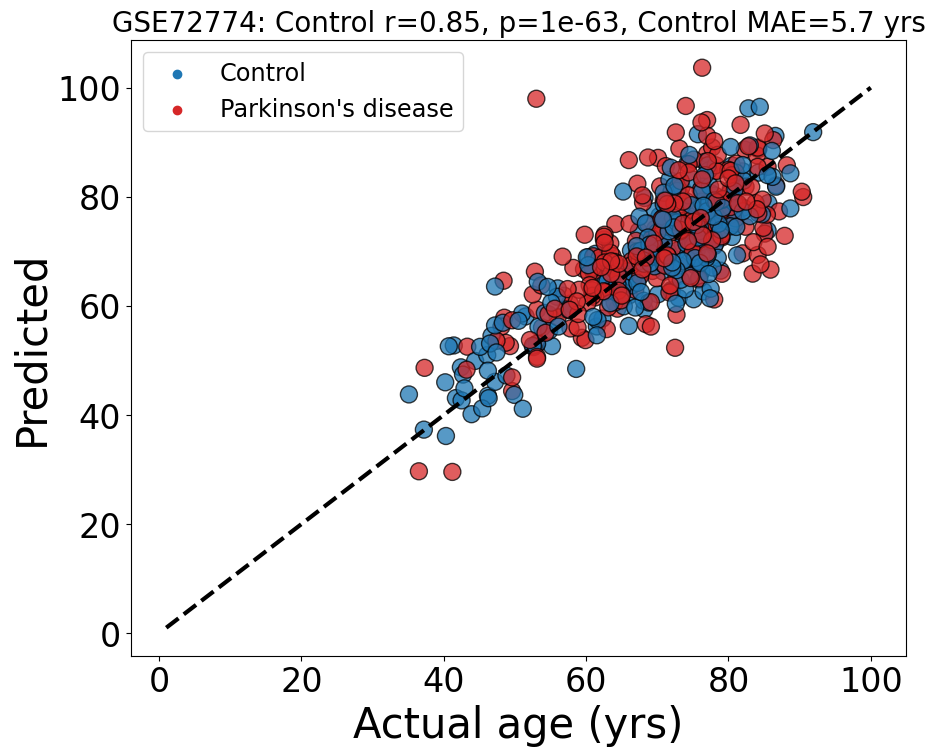

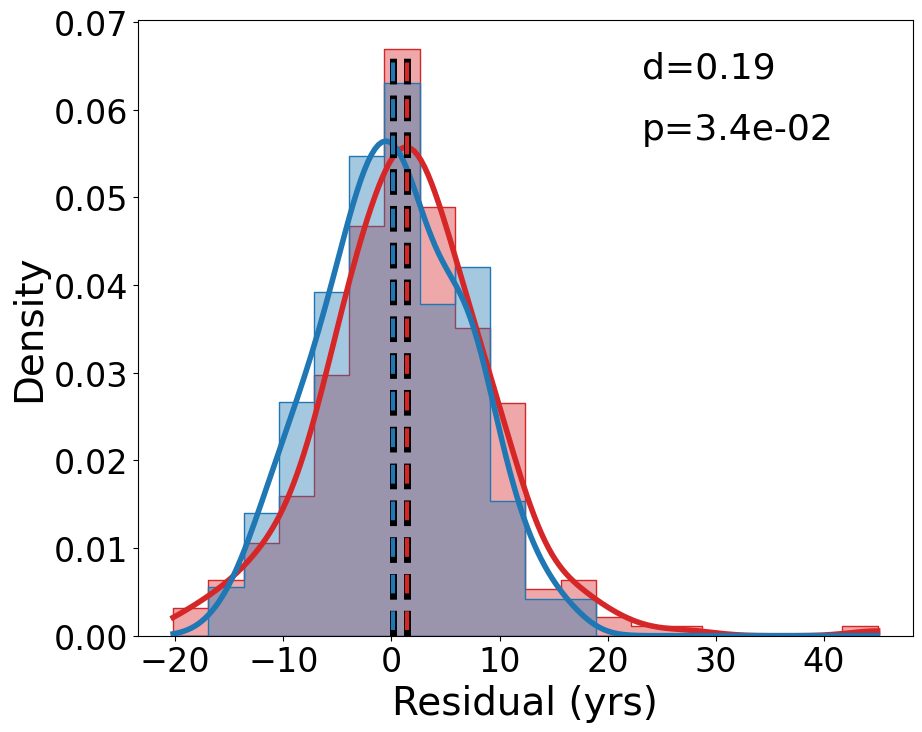

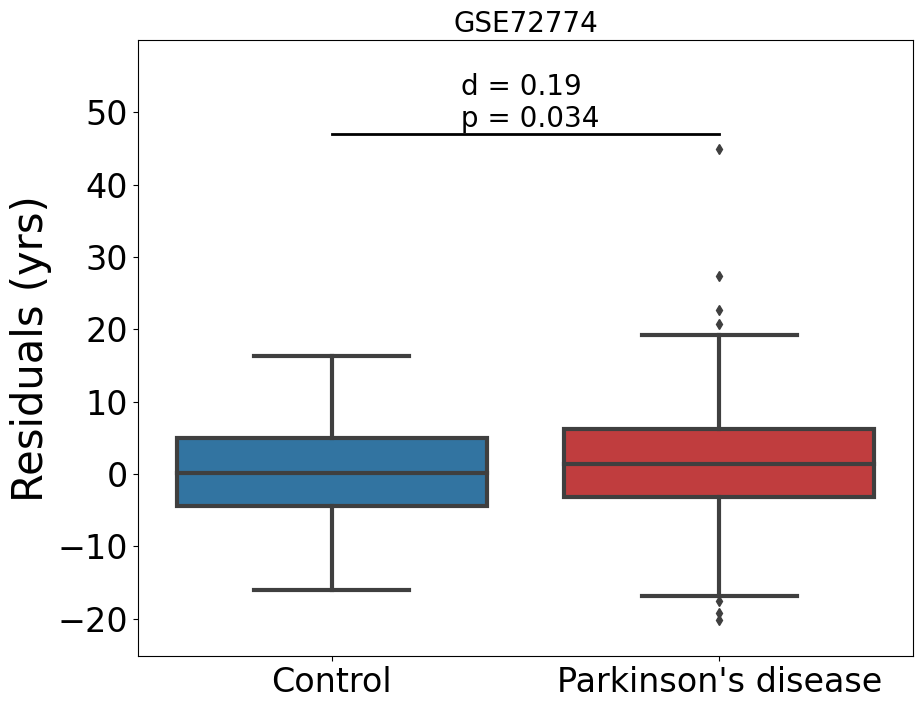

In [349]:
fig4_plots(park, park_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"Parkinson's disease", flag=False)

### Load in GSE125105 (Depression) dataset

In [343]:
dep = np.load(data_path + 'GSE125105_depression/depression32_full.npy', allow_pickle=True)
dep_meta = pd.read_excel(data_path + 'GSE125105_depression/depression_pmeta.xlsx')
cg_list = list_reader(data_path + 'GSE125105_depression/depression_cgs_full.txt')
dep = pd.DataFrame(dep, columns=cg_list)

# Generate Supplementary Figure 4c

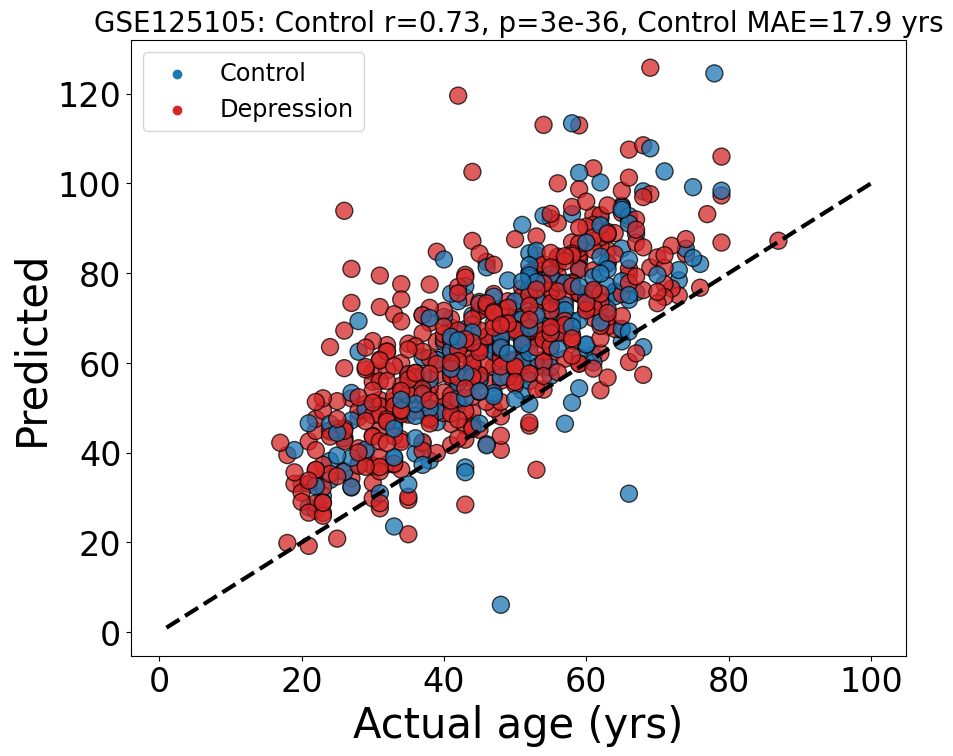

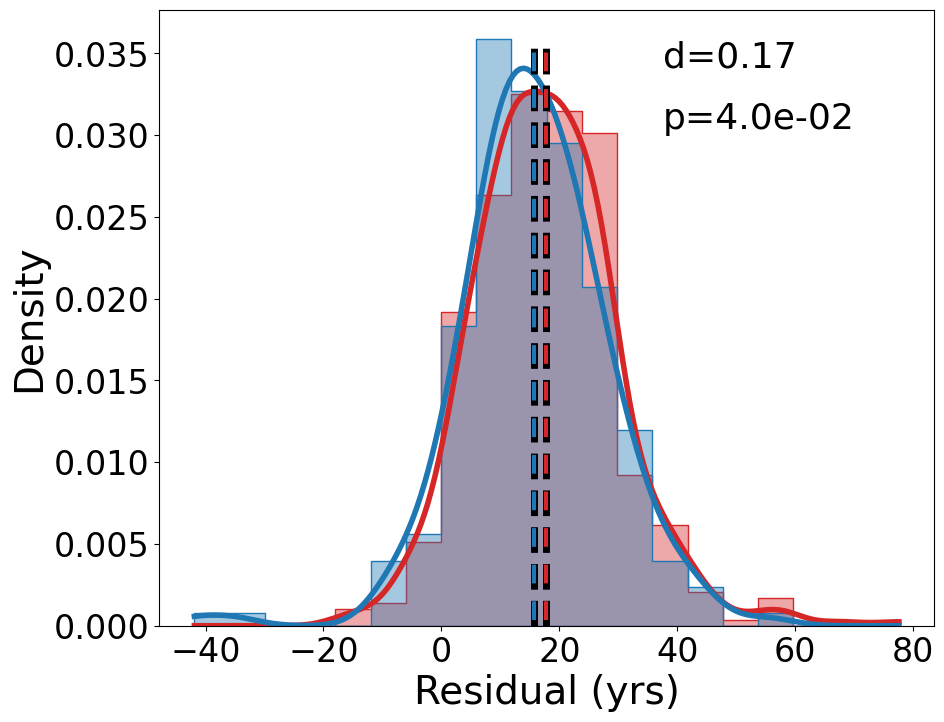

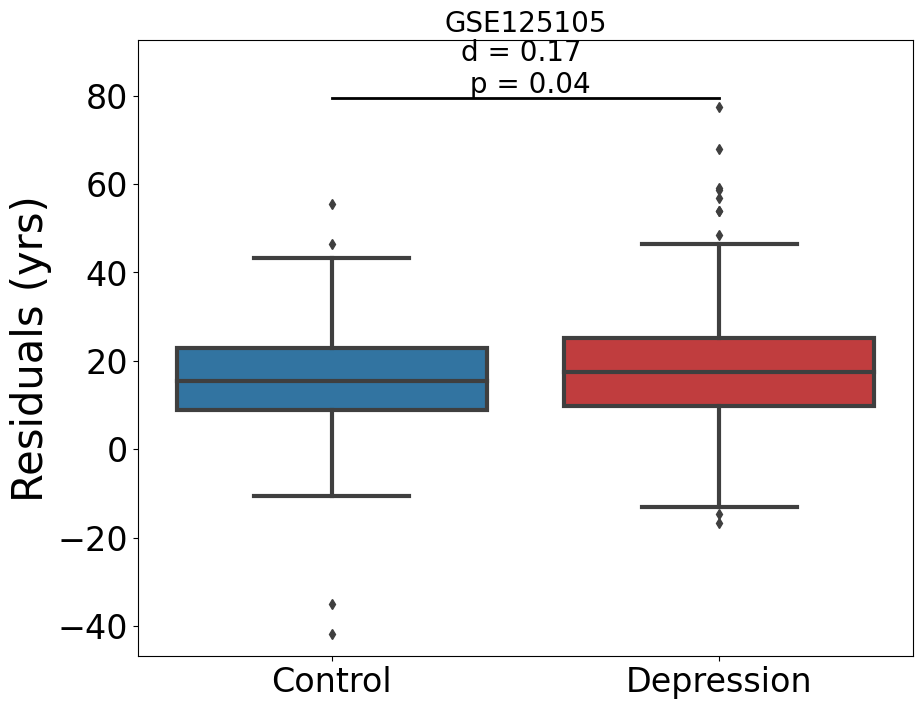

In [350]:
fig4_plots(dep, dep_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"Depression", flag=False)

### Load in GSE106648 (MS) dataset

In [345]:
ms = pd.read_pickle(data_path + 'GSE106648_ms/MS32.pkl')
ms_meta = pd.read_excel(data_path + 'GSE106648_ms/MS_pmeta.xlsx')
from sklearn.impute import KNNImputer
# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=2)
# Fit and transform the DataFrame with the imputer
imputed = imputer.fit_transform(ms)
ms = pd.DataFrame(imputed, columns=ms.columns)

# Generate Supplementary Figure 4d

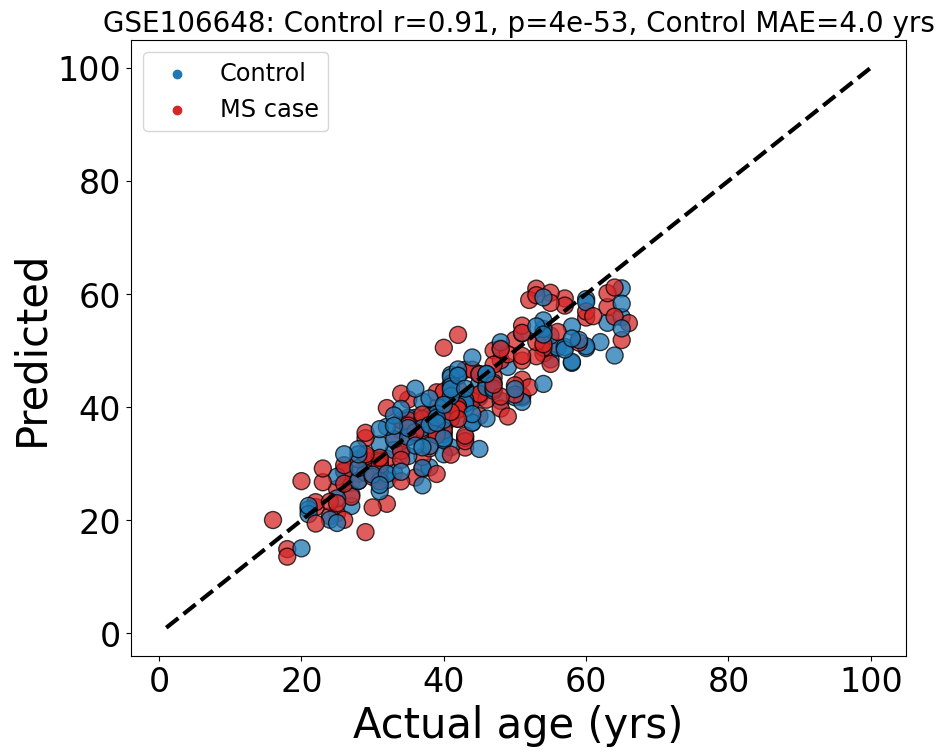

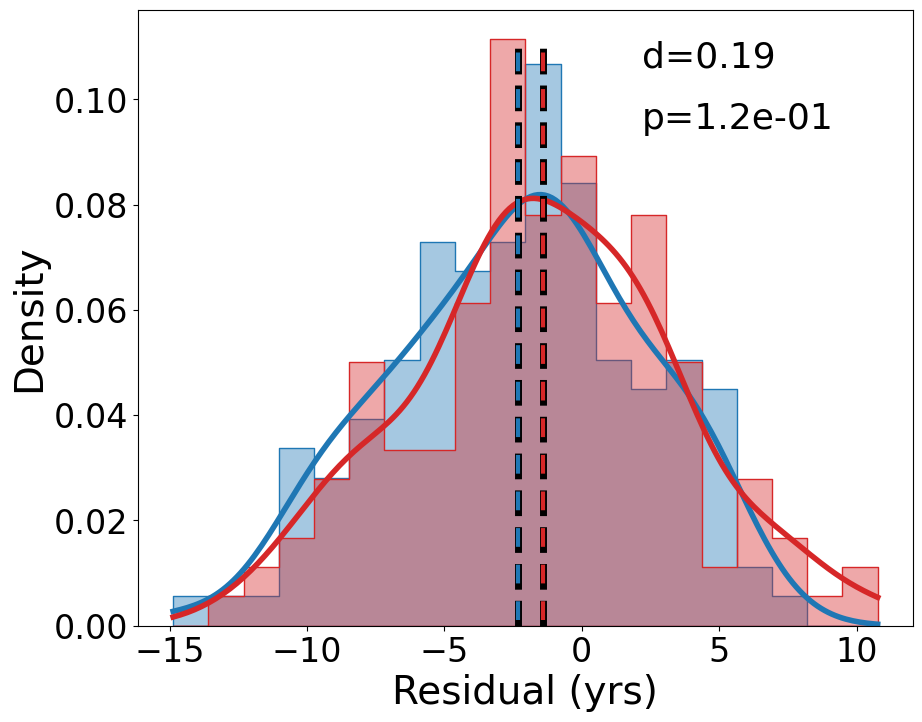

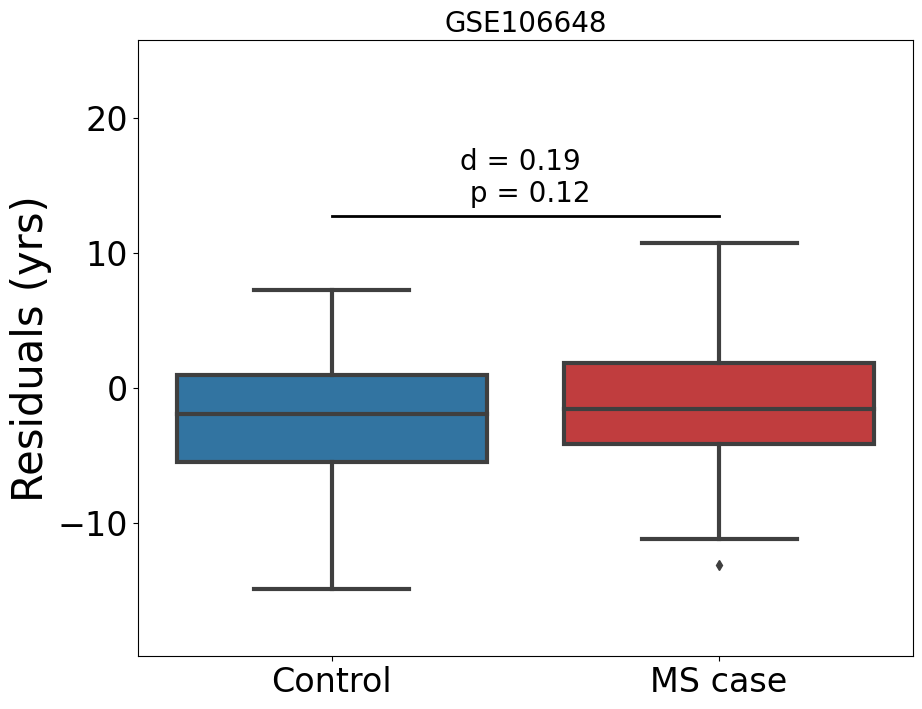

In [351]:
fig4_plots(ms, ms_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"MS case", flag=False)

### Load in GSE53740 (Tauopathy) dataset

In [352]:
tau = np.load(data_path + 'GSE53740_tauopathy/tauopathy32.npy', allow_pickle=True)
tau_meta = pd.read_excel(data_path + 'GSE53740_tauopathy/tauopathy_pmeta.xlsx')
cg_list = list_reader(data_path + 'GSE53740_tauopathy/cgs.txt')
tau = pd.DataFrame(tau, columns=cg_list)

# Generate Supplementary Figure 4e

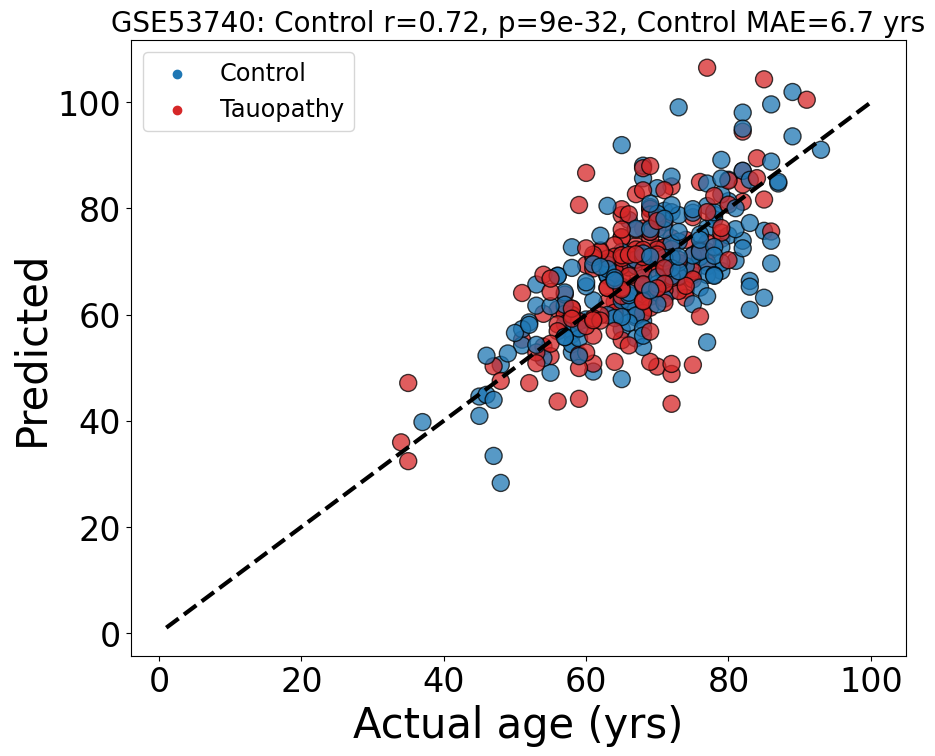

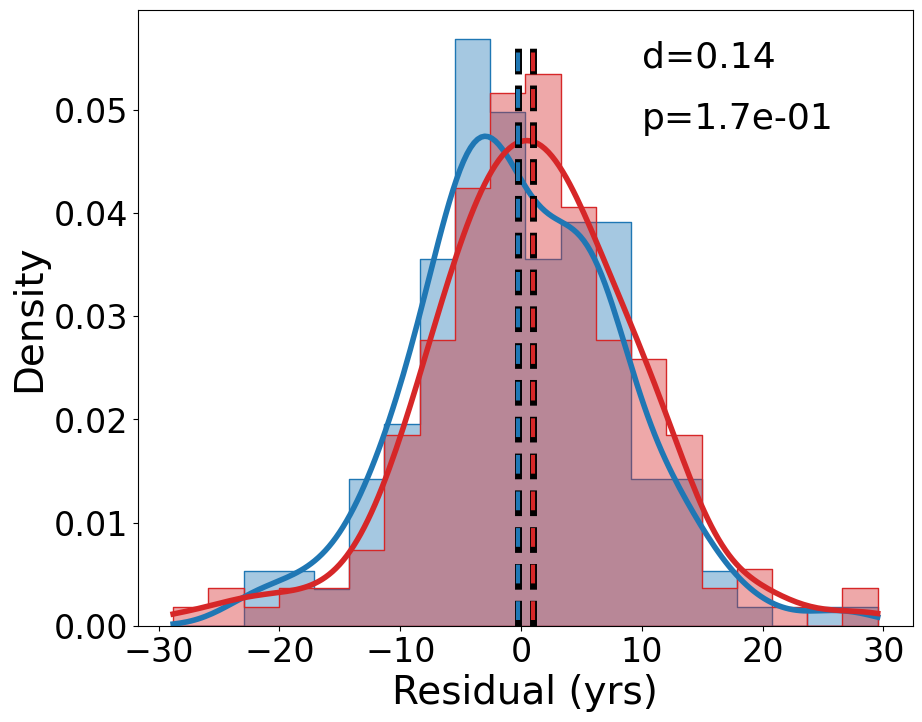

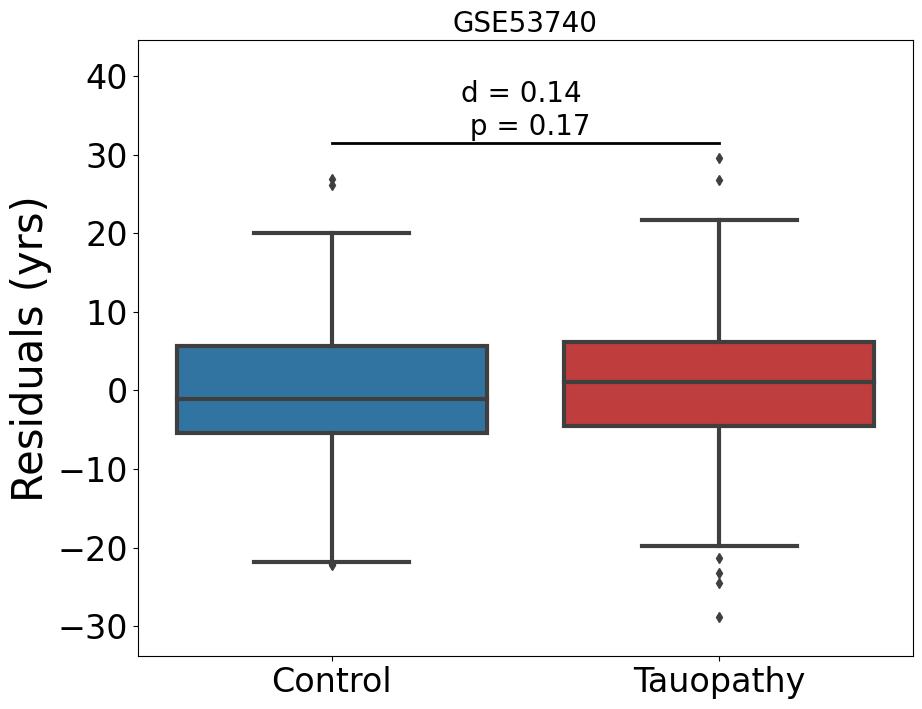

In [353]:
fig4_plots(tau, tau_meta,art_corr_mfss_model,
           art_corr_mfss_selection,d_shift,"Tauopathy", flag=True)

## Train Arthritis-rectified mFSS based on disease shift magnitude

In [354]:
#Re-sort by disease shift magnitude
d_shift['Abs. shift'] = abs(d_shift.Shift)
d_shift.sort_values(by="Abs. shift", inplace=True,ignore_index=True,ascending=False)

In [356]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(d_shift.CpG.tolist(), hannum_transform, hannum_meta,
                                                                             lehne_transform, lehne_meta,800, pos_weights=True)

# Generate Supplementary Figure 5a (top)

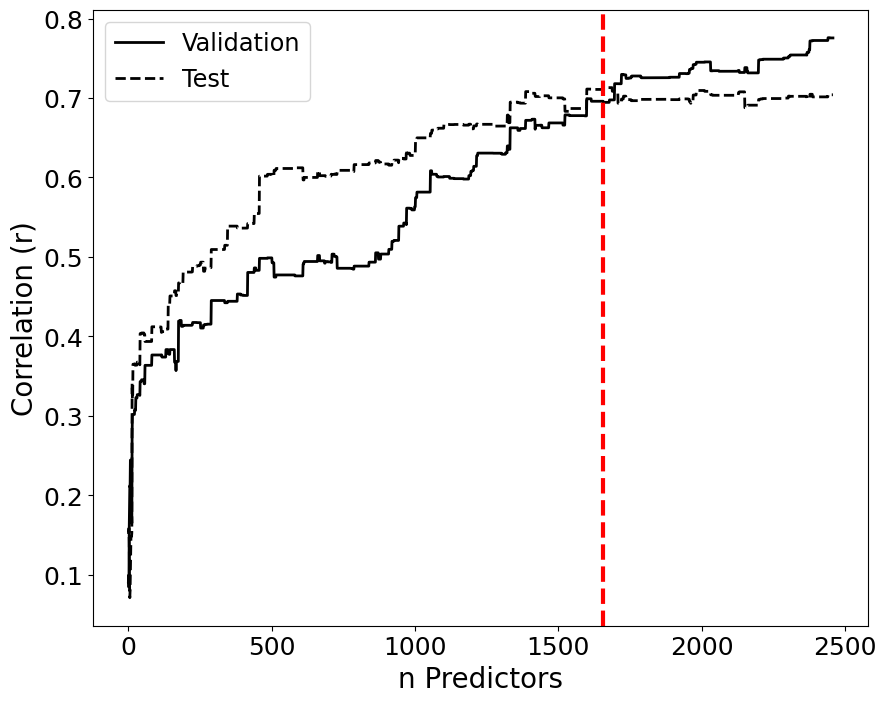

In [365]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20)
plt.ylabel('Correlation (r)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize='xx-large')

# Generate Supplementary Figure 5a (bottom)

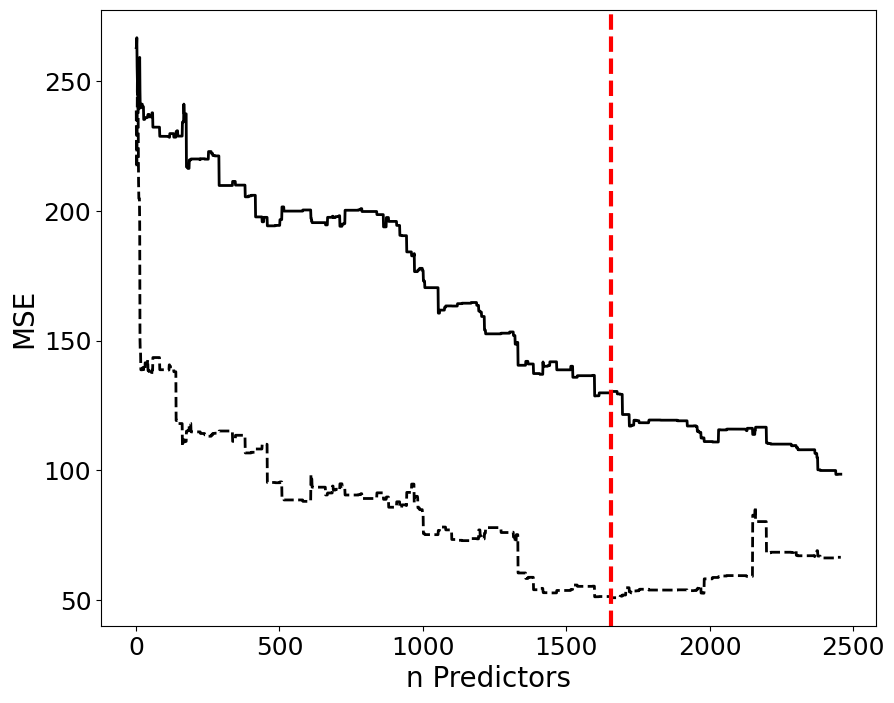

In [366]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20);
plt.ylabel('MSE',fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);

In [359]:
best_iter

1656

### Train the optimized model

In [369]:
art_shift_mfss_selection = d_shift.CpG[:best_iter]
art_shift_mfss_model = LinearRegression(positive=True).fit(hannum_transform[art_shift_mfss_selection], hannum_meta.age)

# Generate Supplementary Figure 5b

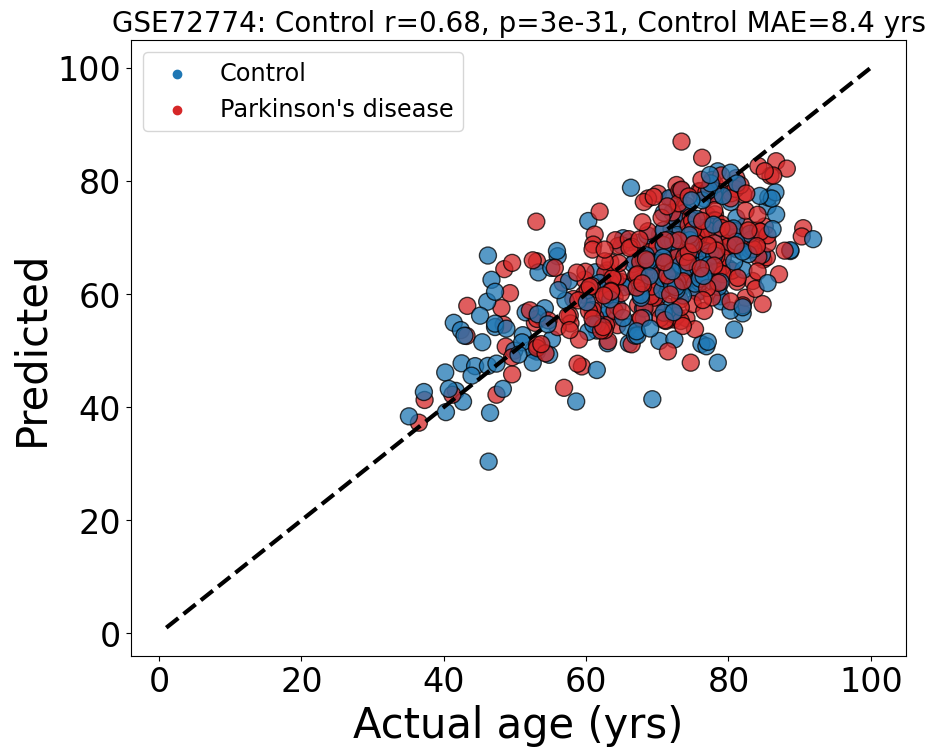

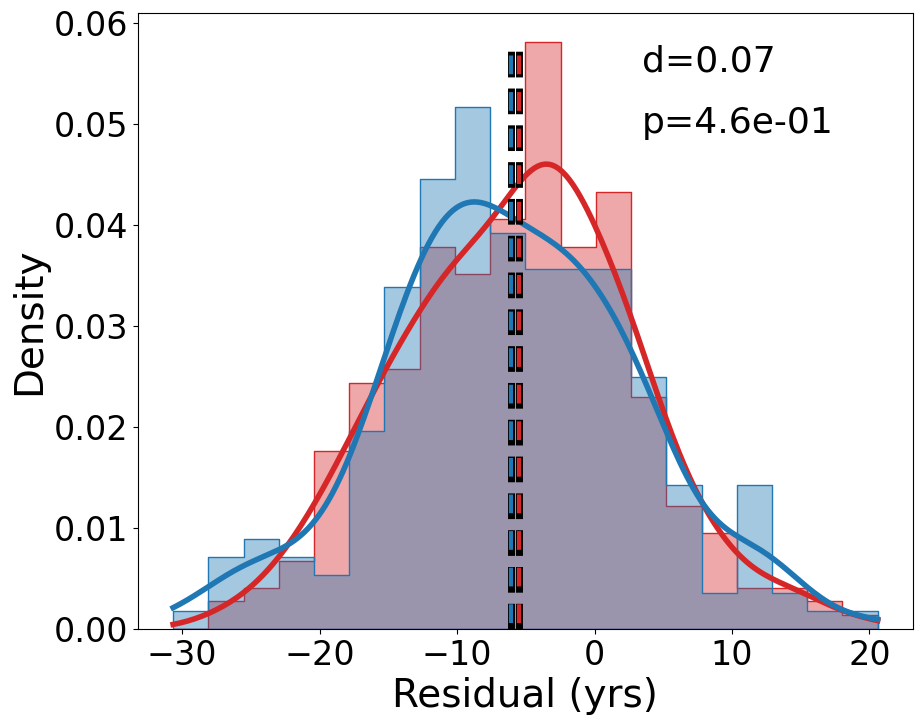

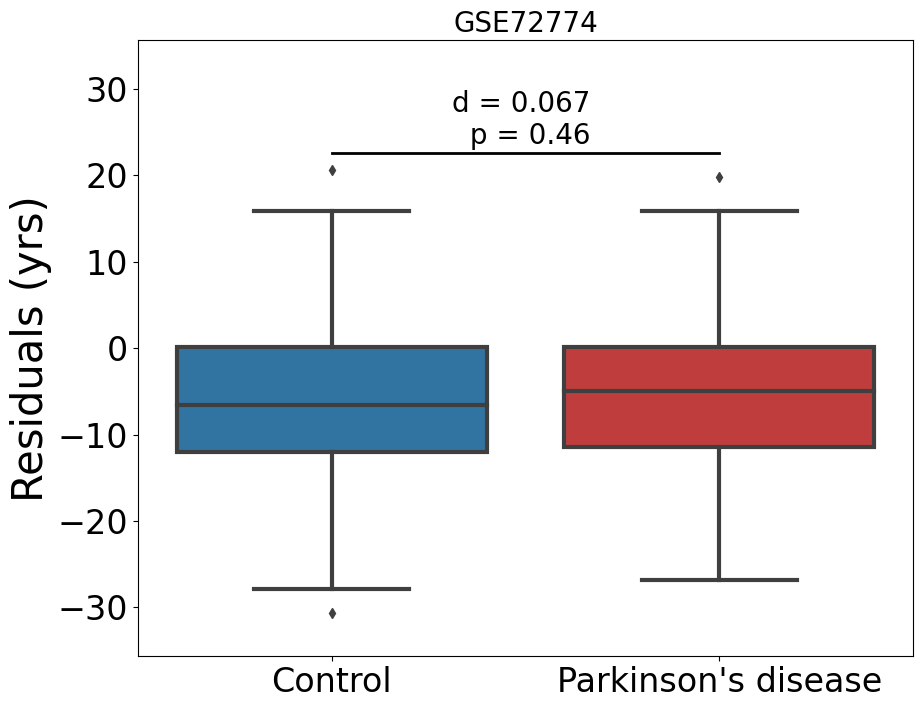

In [370]:
fig4_plots(park, park_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"Parkinson's disease", flag=False)

# Generate Supplementary Figure 5c

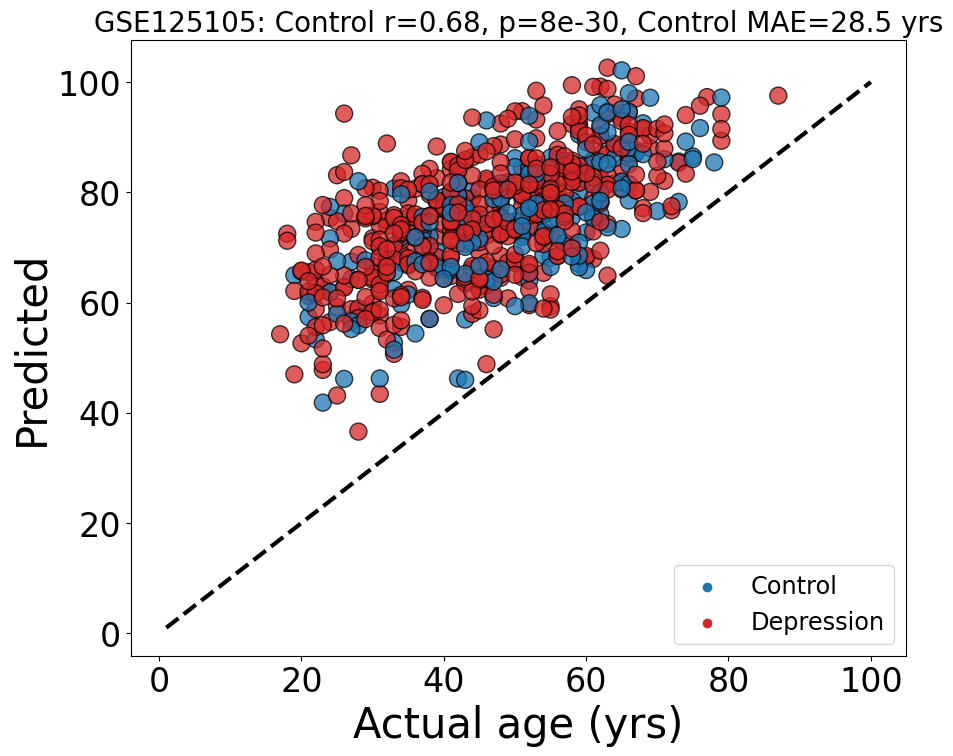

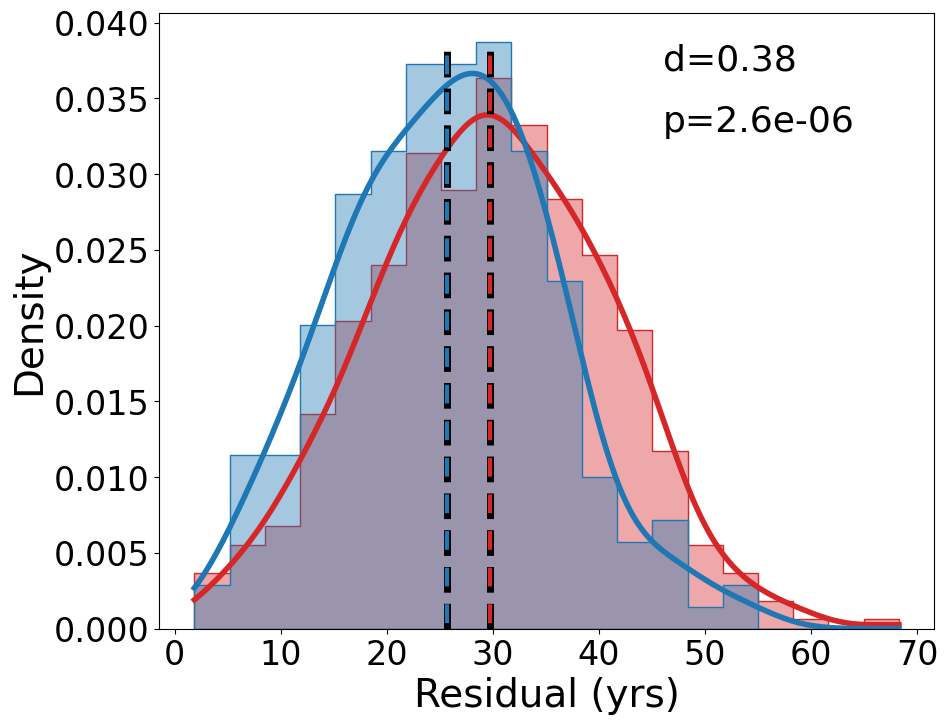

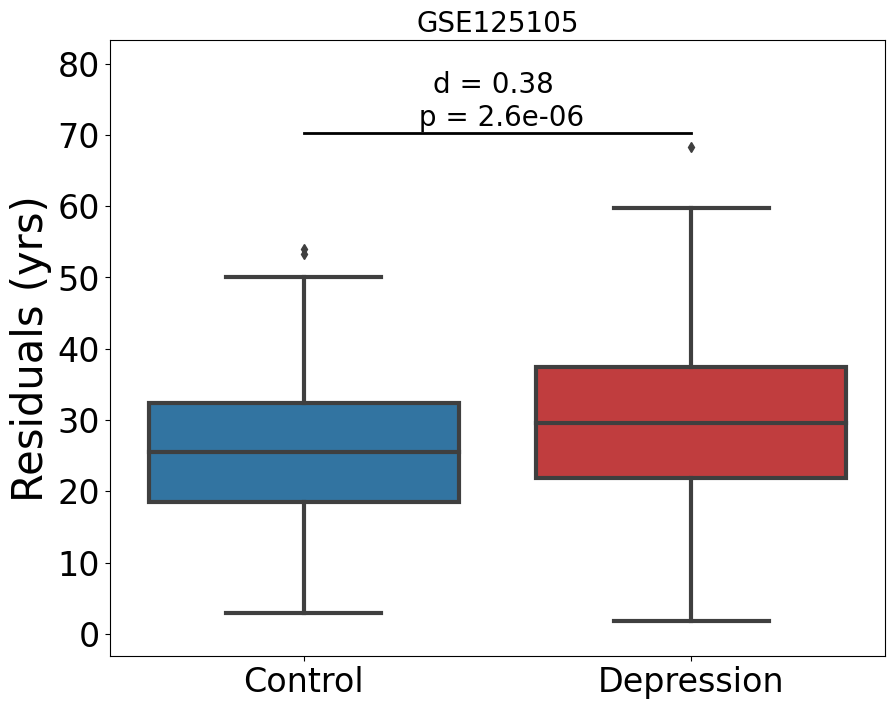

In [371]:
fig4_plots(dep, dep_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"Depression", flag=False)

# Generate Supplementary Figure 5d

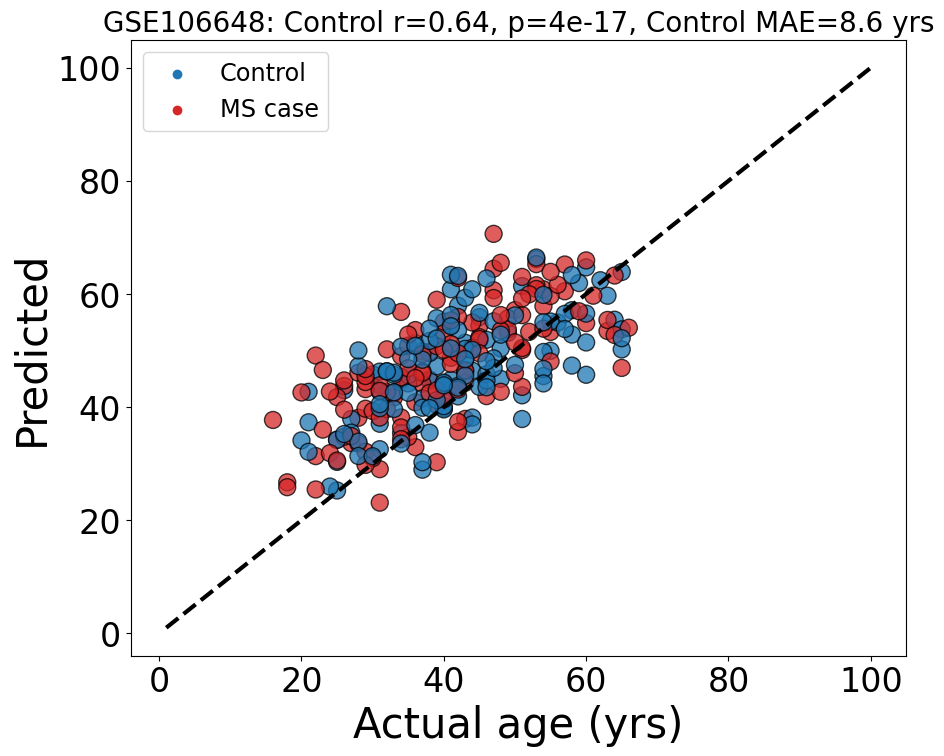

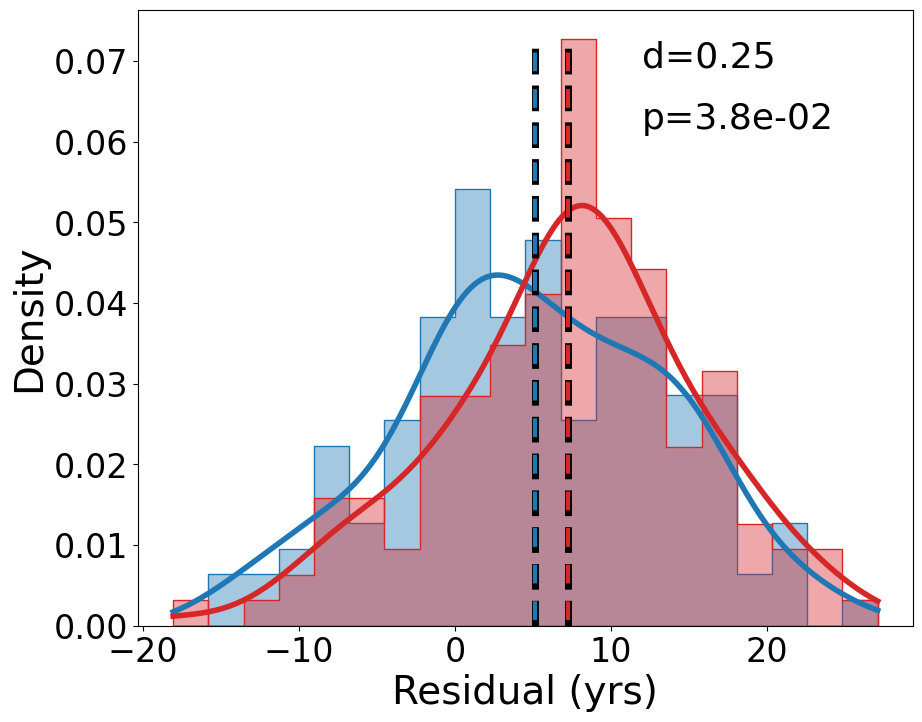

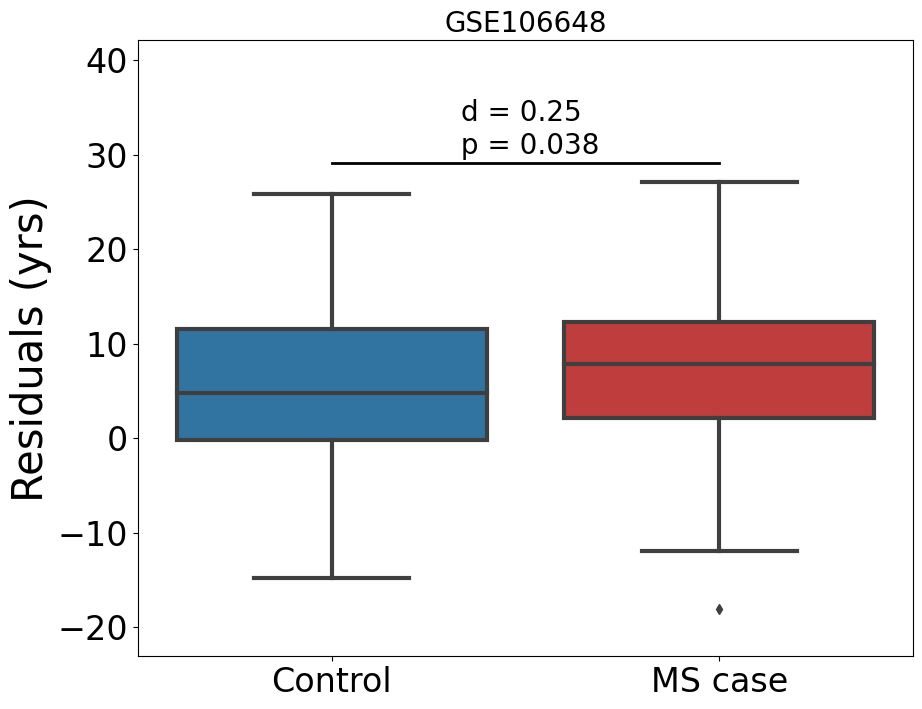

In [372]:
fig4_plots(ms, ms_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"MS case", flag=False)

# Generate Supplementary Figure 5e

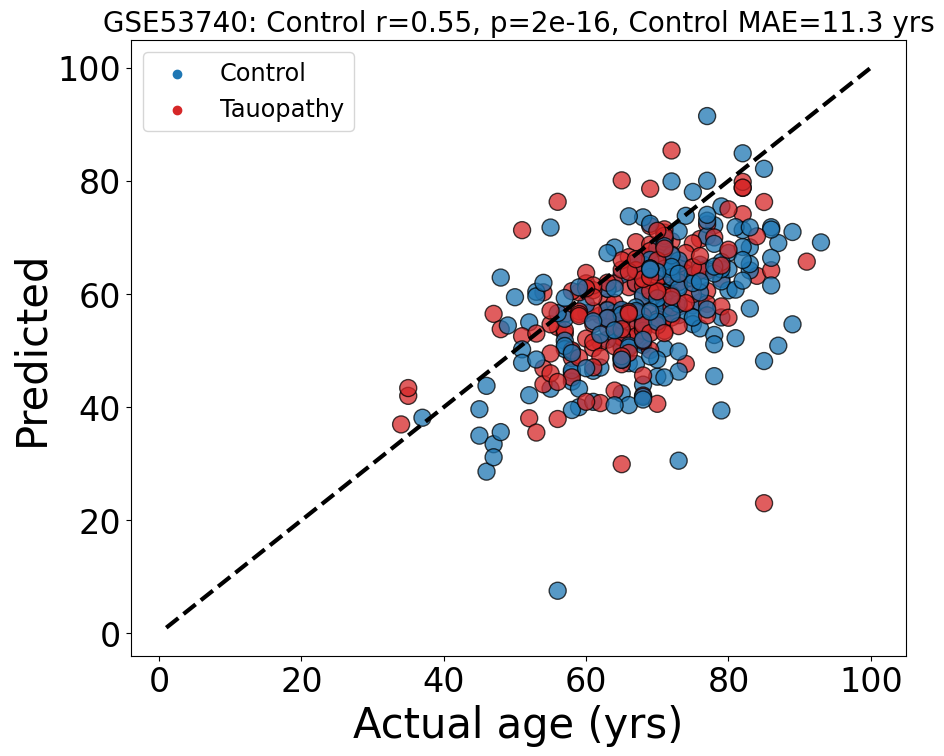

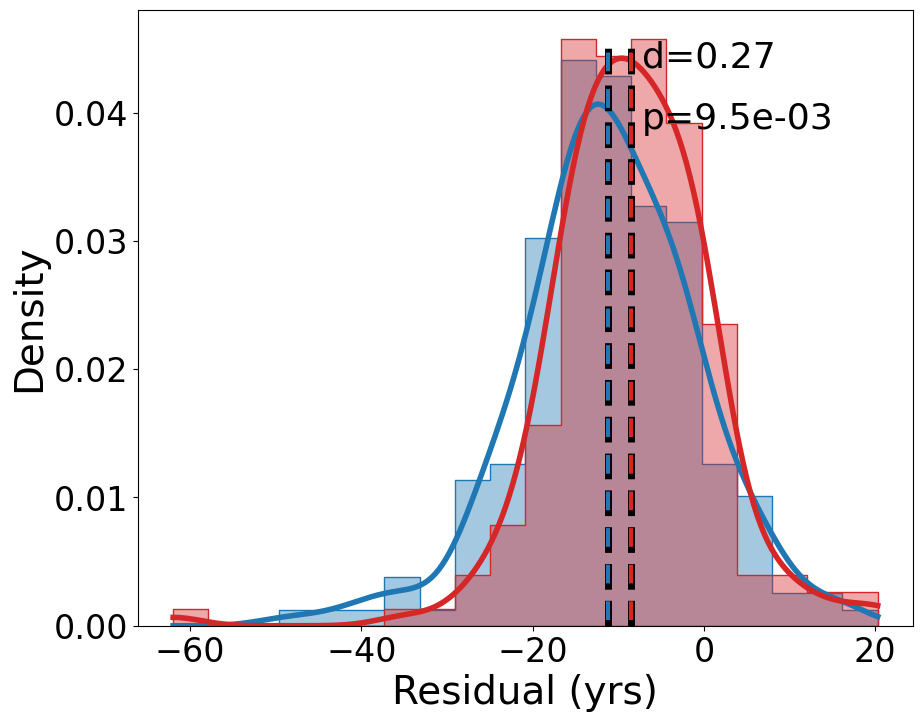

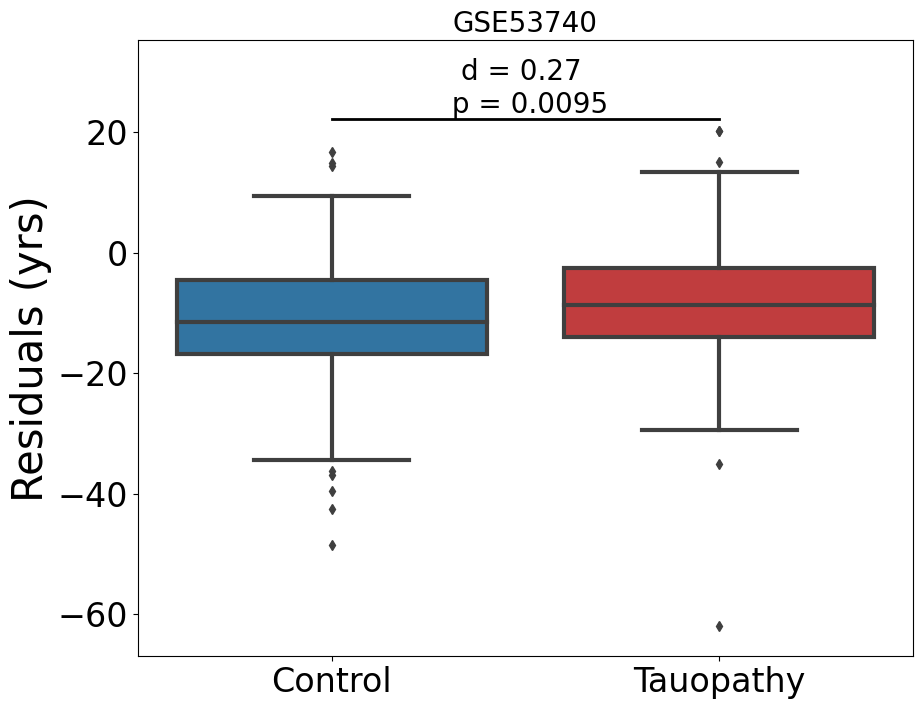

In [373]:
fig4_plots(tau, tau_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"Tauopathy", flag=True)

# Generate Supplementary Figure 5f

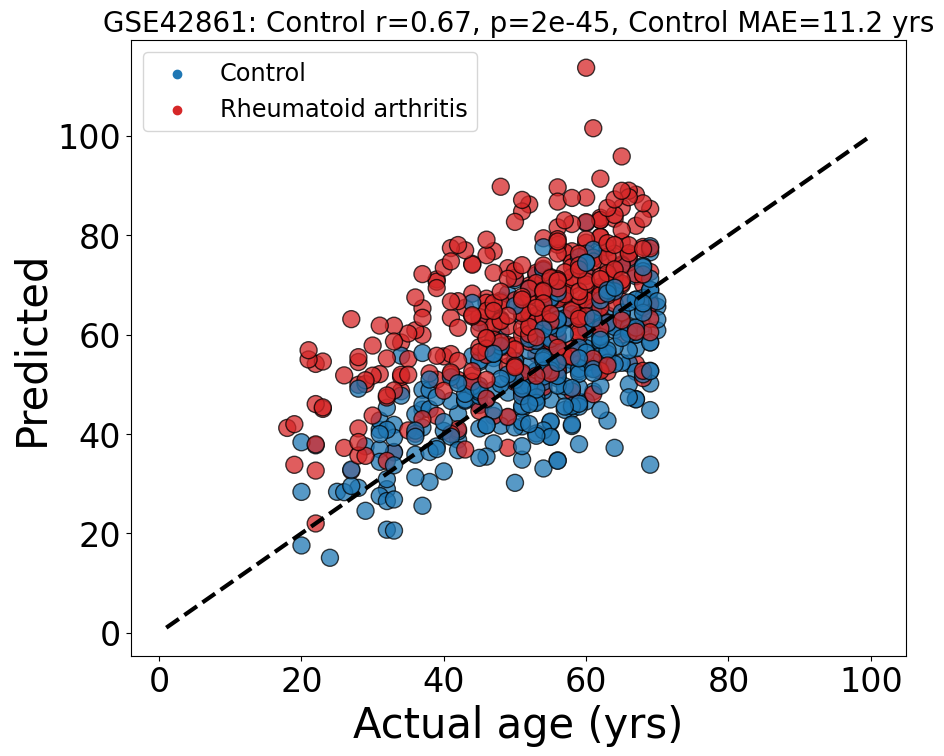

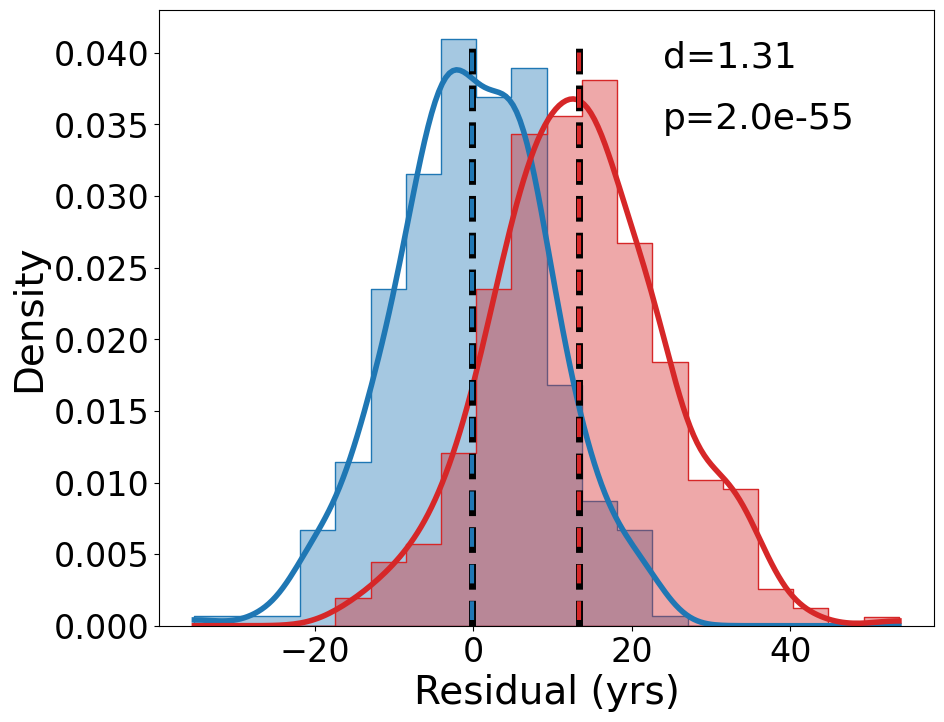

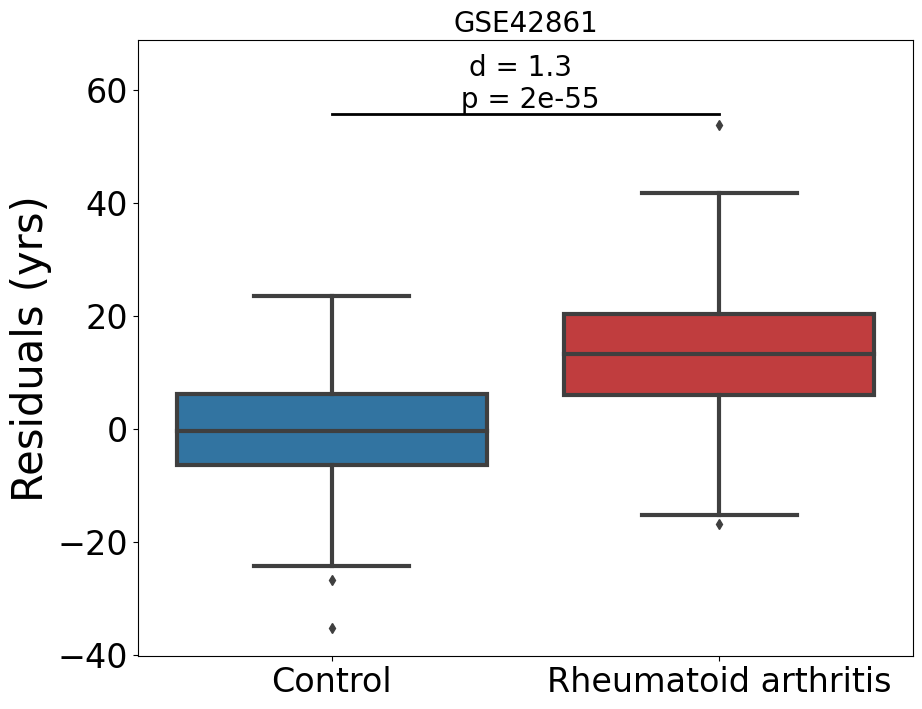

In [374]:
fig4_plots(art, art_meta,art_shift_mfss_model,
           art_shift_mfss_selection,d_shift,"Rheumatoid arthritis", flag=False)

## Load and prep the V7 dataset

In [7]:
h_comb = np.load(data_path + 'combined_v7/V7_healthy.npy', allow_pickle=True)
d_comb = np.load(data_path + 'combined_v7/V7_disease.npy', allow_pickle=True)
cgs=list_reader(data_path + 'combined_v7/V7_cgs.txt')
h_comb = pd.DataFrame(h_comb, columns=cgs)
d_comb = pd.DataFrame(d_comb, columns=cgs)

v7_meta = pd.read_excel(data_path + 'combined_v7/V7_pmeta.xlsx')
h_meta = v7_meta.copy()
d_meta = v7_meta.copy()
h_meta = h_meta[h_meta.disease==0]
d_meta = d_meta[d_meta.disease==1]
h_meta.reset_index(drop=True, inplace=True)
d_meta.reset_index(drop=True, inplace=True)

In [8]:
#combine into one dataset
v7 = pd.concat([h_comb,d_comb],ignore_index=True)
v7_meta = pd.concat([h_meta,d_meta],ignore_index=True)

In [9]:
# Remove the Depression samples from the v7 training dataset and v7 metadata; Depression will be used as a test set
no_dep = v7[v7_meta.series_id!="GSE125105"]
no_dep_meta =v7_meta[v7_meta.series_id!="GSE125105"]

In [13]:
# Ensure no_dep_meta is an independent copy
no_dep_meta = no_dep_meta.copy()

# Create new labels
new_labels = ["Control" if value == 0 else "Inflammaging" for value in no_dep_meta.disease]

# Safely redefine the column
no_dep_meta['disease_state'] = new_labels

In [17]:
up_shift, down_shift = get_shifts(no_dep, no_dep_meta, age_corrs.CpG[:10000], 'Control')
#Combine
d_shift = pd.concat([up_shift,down_shift])
d_shift.reset_index(inplace=True, drop=True)

# #Re-sort by disease shift magnitude
d_shift['Abs. shift'] = abs(d_shift.Shift)
d_shift.sort_values(by="Abs. shift", inplace=True,ignore_index=True,ascending=False)

# Generate Supplementary Table 5

In [19]:
d_shift

,CpG,Shift,Correlation,Cohens d,Sign,Order,Abs. shift
0,cg08450017,8.271058e-02,0.221020,-5.233291,1,7144,8.271058e-02
1,cg09290120,-7.425385e-02,-0.025896,4.754762,-1,8972,7.425385e-02
2,cg02345886,-6.767714e-02,0.084284,4.448234,-1,8071,6.767714e-02
3,cg03607951,-6.714863e-02,0.031040,4.287630,-1,7109,6.714863e-02
4,cg22217449,6.613557e-02,0.353864,-4.656456,1,9307,6.613557e-02
...,...,...,...,...,...,...,...
9995,cg14163776,-5.991465e-06,0.098574,0.000556,-1,4589,5.991465e-06
9996,cg11741201,-4.361600e-06,-0.178769,0.000384,-1,72,4.361600e-06
9997,cg26301489,1.229438e-06,-0.045249,-0.000117,1,5142,1.229438e-06
9998,cg07171111,-9.340503e-07,0.258625,0.000132,-1,1039,9.340503e-07


In [18]:
#get the transformed data for the training (Hannum), validation (Lehne), and test (v7) sets

hannum_transform = coherence_transform(hannum, d_shift)
print("Done")
lehne_transform = coherence_transform(lehne, d_shift)
print("Done")
no_dep_transform = coherence_transform(no_dep, d_shift)

Done
Done


In [21]:
model_cgs, best_iter, val_mse, val_r_val, test_mse, test_r_val = mfss_ols(d_shift.CpG.tolist(), hannum_transform, hannum_meta,
                                                                             lehne_transform, lehne_meta, 1800,pos_weights=True)

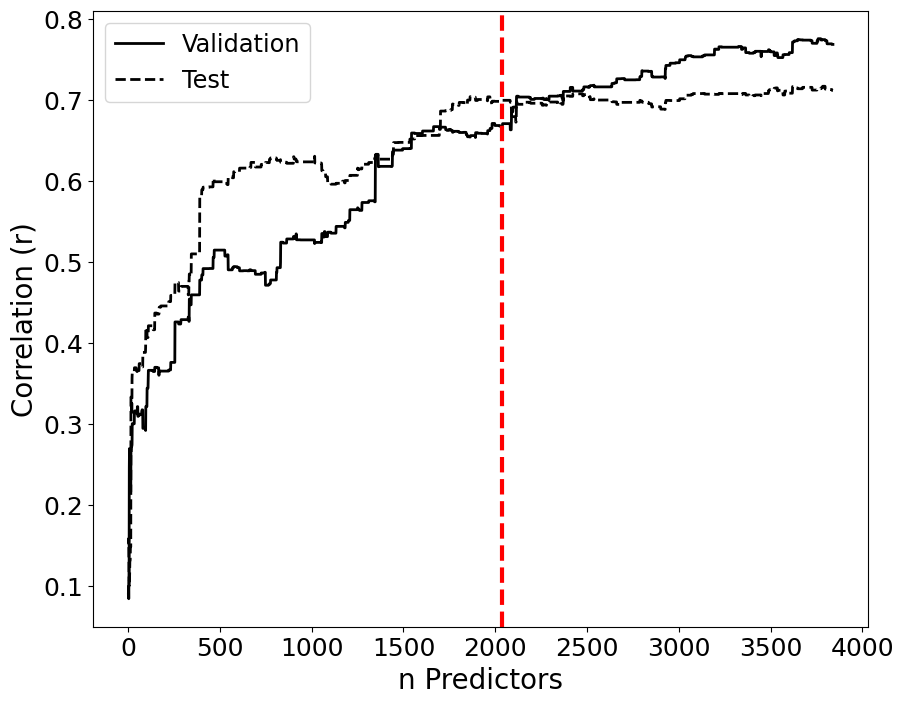

In [22]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_r_val, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_r_val, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20)
plt.ylabel('Correlation (r)',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize='xx-large')

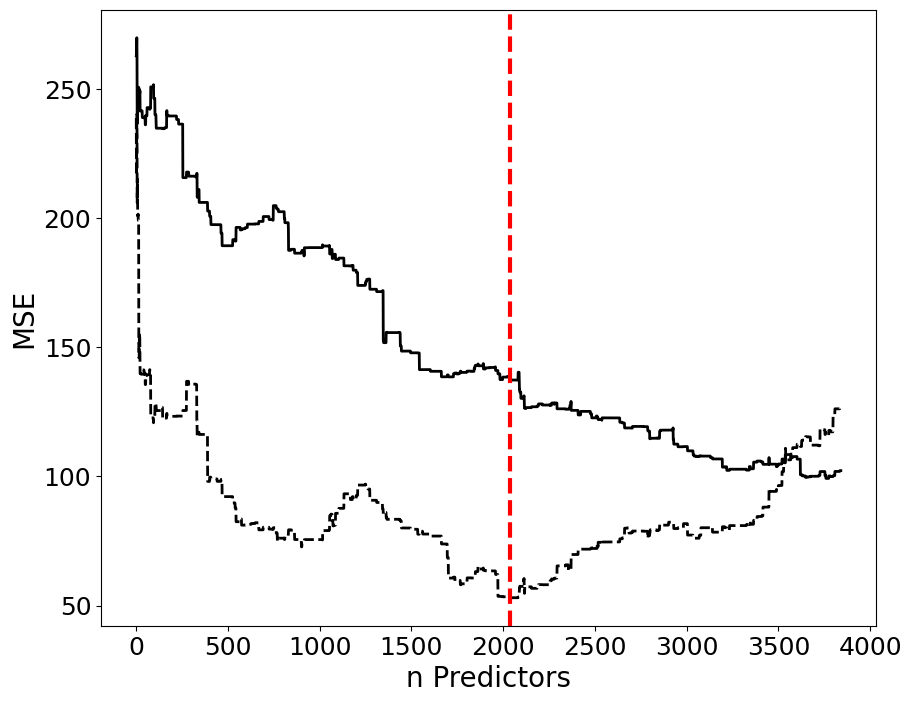

In [23]:
plt.figure(figsize=(10, 8)) 
x_lim = len(model_cgs)
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),val_mse, c='k',linewidth=2, label='Validation' )
plt.plot(np.linspace(1,x_lim,x_lim,dtype=int),test_mse, c='k',linewidth=2, linestyle='dashed', label='Test')
plt.axvline(x=best_iter, color='red', linestyle='--',linewidth=3)

plt.xlabel('n Predictors', fontsize=20);
plt.ylabel('MSE',fontsize=20);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);